<a href="https://colab.research.google.com/github/nobertomaciel/PLN-ANIMA/blob/main/UA2/PLN_speech_recognition_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 1.5648 - val_loss: 1.1843
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.9630 - val_loss: 0.7617
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.7116 - val_loss: 0.6927
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.6931 - val_loss: 0.6925
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.6929 - val_loss: 0.6922
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

=== MÉTRICAS ===
Acurácia: 0.5
F1-score: 0.3333333333333333
WER: 0.5
CER: 0.5
BLEU: 9.109159947226709e-232


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

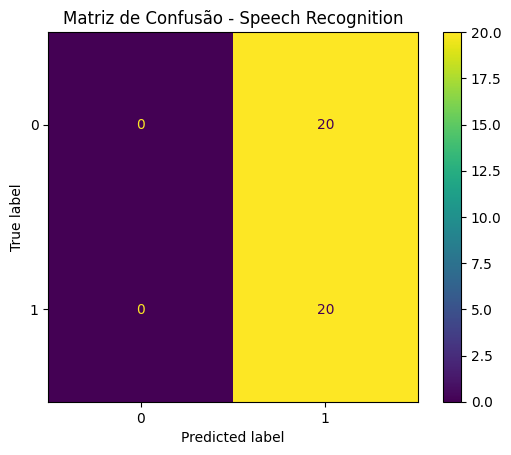

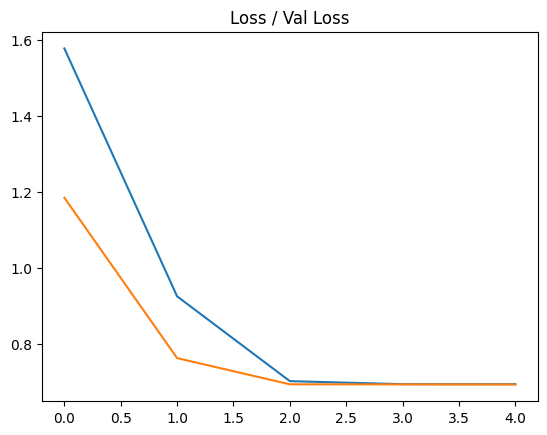

In [3]:
# ============================================
#  RECONHECIMENTO DE VOZ - SIMPLIFICADO (CNN)
# ============================================
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from jiwer import wer, cer
import tensorflow as tf
from tensorflow.keras import layers, models

# -------------------------------------------------------
# GERAR DADOS SINTÉTICOS (demonstrativo educacional)
# -------------------------------------------------------
def gerar_exemplo():
    sr = 16000
    audio = np.random.randn(sr)  # ruído como áudio simulado
    label = np.random.choice(["sim", "não"])
    return audio, label

audios = []
labels = []

for _ in range(200):
    x, y = gerar_exemplo()
    audios.append(x)
    labels.append(0 if y == "sim" else 1)

# -------------------------------------------------------
# CONVERTE PARA MEL-SPECTROGRAM
# -------------------------------------------------------
def audio_to_mel(aud):
    mel = librosa.feature.melspectrogram(y=aud, sr=16000)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

X = np.array([audio_to_mel(a) for a in audios])
X = X[..., np.newaxis]
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# -------------------------------------------------------
# MODELO CNN SIMPLES
# -------------------------------------------------------
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

# -------------------------------------------------------
# PREDIÇÕES
# -------------------------------------------------------
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

# ============================================
#  BLOCO PADRÃO DE MÉTRICAS (USADO NOS 3 CÓDIGOS)
# ============================================
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from nltk.translate.bleu_score import sentence_bleu

print("\n=== MÉTRICAS ===")
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("Acurácia:", acc)
print("F1-score:", f1)

# Como ASR envolve texto, criamos exemplos fictícios:
true_sentences = ["sim" if t == 0 else "não" for t in y_test]
pred_sentences = ["sim" if p == 0 else "não" for p in y_pred]

print("WER:", wer(true_sentences, pred_sentences))
print("CER:", cer(true_sentences, pred_sentences))

bleu = np.mean([sentence_bleu([ts.split()], ps.split())
                for ts, ps in zip(true_sentences, pred_sentences)])
print("BLEU:", bleu)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Matriz de Confusão - Speech Recognition")
plt.show()

# Plot de acurácia/validação
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss / Val Loss")
plt.show()
